## Notebook Topic

This notebook demonstrates an applied computer vision workflow for transferring object detections between video frames using planar homography.

The task is to reuse a previously developed homography-based transfer function (and its helper utilities) to project detections from an initial reference frame onto subsequent frames that share an overlapping field of view.

The pipeline combines:
- feature matching (SIFT) to estimate the homography matrix,
- object detection (YOLOv8) to obtain bounding boxes on the reference frame,
- geometric projection of bounding boxes onto the target frame,
- coordinate normalization and result visualization.


# Solution


## 1. Download and Extract Materials

The required files (video and frames) can be downloaded from the provided link.

Two options are supported:
- download the archive programmatically inside Colab,
- or upload the archive manually into the `/content` directory.

After downloading, the archive is extracted into the current working directory.


In [ ]:
!wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/PW8tu63_1JoCqg -O ДЗ_pro.zip

--2024-09-04 10:18:59--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/PW8tu63_1JoCqg
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/0dd26578c02a80983e066d164e456aa38337d50b38b2122c90020018185be4b6/66d86b8f/m9X72i1O9v6qpKuLJoX2BaMCtsg-L55LMiAmGZBRRM02hvlfpSvzMYowGw5ro5967XjoNPn--IfwlLATXCR2Rg%3D%3D?uid=0&filename=%D0%94%D0%97_pro.zip&disposition=attachment&hash=W7hpau9Y98sCYhXMXhhVTD6jF/sRnJCuVysVuT2lLowzxikzurEJlL%2BvPLy6n4OTq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=1572215809&fsize=6212912&hid=f6960a25de3ccadee54db6a835f9728d&media_type=compressed&tknv=v2 [following]
--2024-09-04 10:18:59--  https://downloader.disk.yandex.ru/disk/0dd26578c02a80983e066d164e456aa38337d50b38b2122c90020018185be4b6/66d86b8f/m9X72i1O9v6qpKuLJoX2

In [ ]:
# Извлечение датасета в текущую директорию
from zipfile import ZipFile
with ZipFile('ДЗ_pro.zip', "r") as zip_file:
   zip_file.extractall('.')

## 2. Install Dependencies


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 5.4 MB/s eta 0:00:00


## 3. Import Libraries


In [ ]:
import os
from IPython.display import HTML
from base64 import b64encode
import torch
import cv2
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ultralytics
import supervision as sv
import datetime
from typing import Union, Optional, List

## Функции и классы

## 4. Helper Functions and Utilities

This section collects all helper functions required for the assignment.

They support:
- video visualization,
- bounding box handling and drawing,
- homography estimation via feature matching,
- coordinate projection using a homography matrix,
- bounding box normalization after projection.

These utilities are later used inside a single integrated function
that transfers detections between overlapping camera views.


In [ ]:
# Utility function for displaying video files inside a notebook

def show_video(path: str):
  path_compressed = path.removesuffix(".mp4") + "_compressed.mp4"
  os.system(f"ffmpeg -i {path} -vcodec libx264 {path_compressed}")

  with open(path_compressed, "rb") as video:
    mp4 = video.read()

  os.remove(path_compressed)

  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""
  <video width=700 controls>
        <source src="{data_url}" type="video/mp4">
  </video>
  """)

In [ ]:
# Utility function to extract diagonal corner points from a bounding box coordinate array

def get_bbox_points(annotation: np.ndarray) -> tuple[tuple[int, int], tuple[int, int]]:
    """
    Extracts diagonal corner points from a bounding box.

    Args:
        annotation: array of bounding box coordinates [x1, y1, x2, y2]

    Returns:
        A tuple containing two coordinate pairs representing diagonal corners.
    """
    point1 = [annotation[0], annotation[1]]
    point2 = [annotation[2], annotation[3]]
    return [point1, point2]

In [ ]:
# Function for annotating an image with bounding boxes

def plot_annotated_image(image: np.ndarray, bboxes_coords: np.ndarray) -> np.ndarray:
    """
    Annotates an image with bounding boxes.

    Args:
        image: input image as a NumPy array
        bboxes_coords: array of bounding box coordinates [x1, y1, x2, y2]

    Returns:
        Annotated image as a NumPy array.
    """


    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # вычисление толщины линий в зависимости от размера изображения
    new_image = image.copy()
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    for box_num, annotation in enumerate(bboxes_coords):
        p1, p2 = get_bbox_points(annotation)

        cv2.rectangle(
            new_image,
            p1, p2,
            color=(0, 255, 0),
            thickness=lw,
            lineType=cv2.LINE_AA)

    return new_image

In [ ]:
# Normalization of bounding box coordinates after homography transformation

def normalize_bboxes_coords(bboxes_coords: np.ndarray, image_width: int, image_height: int, classes_labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Normalizes bounding box coordinates after homography transformation.

    The function:
    - clips negative coordinates to zero,
    - limits coordinates to image width and height,
    - removes degenerate bounding boxes collapsed into lines or points.

    Args:
        bboxes_coords: array of transformed bounding box coordinates
        image_width: target image width
        image_height: target image height
        classes_labels: class labels corresponding to bounding boxes

    Returns:
        A tuple containing normalized bounding boxes and corresponding class labels.
    """

    # приведение всех отрицательных значений координат к нулю
    bboxes_coords[bboxes_coords < 0] = 0

    non_negative_bboxes_coords = []
    for annotation in bboxes_coords:
        non_negative_annotation = []
        points = get_bbox_points(annotation)
        # нормализация координат ббоксов в пределы максимальных размеров изображения
        for point in points:
            # нормализация координат ширины изображения
            if point[0] > image_width:
                point[0] = image_width
            # нормализация координат высоты изображения
            if point[1] > image_height:
                point[1] = image_height
            non_negative_annotation.append(point)
        non_negative_bboxes_coords.append(non_negative_annotation)
    # удаление ббоксов выродившихся в линию после нормализации
    non_negative_bboxes_coords = np.array(non_negative_bboxes_coords).reshape(-1, 4)
    normalized_bboxes_coords = []
    normalized_classes_labels = []
    for annotation, class_label in zip(non_negative_bboxes_coords, classes_labels):
        if annotation[0] == 0 and annotation[2] == 0: # проверяем вырождение в линию по х
            continue
        elif annotation[1] == 0 and annotation[3] == 0: # проверяем вырождение в линию по y
            continue
        elif annotation[2] == 0 or annotation[3] == 0:  # проверяем, что вторая точка ббокса не имеет нулевых координат (вырождение ббокса в точку)
            continue
        normalized_bboxes_coords.append(annotation)
        normalized_classes_labels.append(class_label)
    normalized_bboxes_coords = np.array(normalized_bboxes_coords)
    normalized_classes_labels = np.array(normalized_classes_labels)

    return normalized_bboxes_coords, normalized_classes_labels

In [1]:
# Function for filtering matching feature point indices between two images

def filter_matches_indexes(descriptions_1, descriptions_2):
    """
    Filters matching feature point indices using descriptor similarity.

    Args:
        descriptions_1: descriptors from the first image
        descriptions_2: descriptors from the second image

    Returns:
        List of index pairs for matching keypoints.
    """

    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptions_1, descriptions_2, k=2)
    filtered_indexes = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            filtered_indexes.append([m.queryIdx, m.trainIdx])
    return filtered_indexes

In [ ]:
# Applies a homography matrix to a set of 2D points

def apply_homography(H, points):
    """
    Applies a homography transformation to 2D points.

    Args:
        H: homography matrix
        points: list of (x, y) coordinates

    Returns:
        Transformed points as integer pixel coordinates.
    """

    pts_ = []
    for x, y in points:
        pt_ = H @ np.reshape([x, y, 1.0], newshape=(3, 1))
        x_ = pt_[0] / pt_[-1] # приводим результат трансформации однородых координат в декартовые координаты (проецируем результат на плоскость z = w = 1)
        y_ = pt_[1] / pt_[-1] # приводим результат трансформации однородых координат в декартовые координаты (проецируем результат на плоскость z = w = 1)
        pts_.append([x_, y_])
    return np.intp(pts_)

In [ ]:
# Computes a homography matrix between two images using SIFT feature matching

def compute_sift_homography_matrix(points_num, image_1_grayscale, image_2_grayscale):
    """
    Computes a homography matrix between two images using SIFT keypoints.

    Args:
        points_num: number of SIFT keypoints
        image_1_grayscale: first image in grayscale
        image_2_grayscale: second image in grayscale

    Returns:
        Homography matrix mapping image 1 to image 2.
    """
    sift = cv2.SIFT_create(points_num) # в переменной sift создаем экземпляр класса cv2.SIFT, обеспечивающего вычислене ключевых точек и дескрипторов на изображениях
                                       # параметр 1000 задает вычисление 1000 ключевых точек и дескрипторов
    key_pts_image_1, desc_image_1 = sift.detectAndCompute(image_1_grayscale, None) # методом detectAndCompute вычисляем ключевые точки на 1-м изображении
    key_pts_image_2, desc_image_2 = sift.detectAndCompute(image_2_grayscale, None) # методом detectAndCompute вычисляем ключевые точки на 2-м изображении

    filtered_indexes = np.intp(filter_matches_indexes(desc_image_1, desc_image_2)) # находим точки, сходство которых выше требуемого порога

    # если нет найденных сходных точек на обоих изображениях или их количество менее минимальных 4-х, то это означает что изображения не имеют общей области обзора
    # в таком случае этом завершаем работу функции с выводом соответствующего сообщения
    if len(filtered_indexes) < 4:
        text = 'Изображения не имеют общей области обзора, построение матрицы гомографии невозможно'
        print('', text, '='*len(text), '', sep='\n')
    # иначе выполняем извлечение кортежей координат ключевых точек
    else:
        key_pts_image_1_rounded = np.intp([key_pts.pt for key_pts in key_pts_image_1])
        key_pts_image_2_rounded = np.intp([key_pts.pt for key_pts in key_pts_image_2])

    # фильтруем ключевые точки по порогу
    key_pts_image_1_filtered = key_pts_image_1_rounded[filtered_indexes[:, 0]]
    key_pts_image_2_filtered = key_pts_image_2_rounded[filtered_indexes[:, 1]]

    # вычисляем матрицу гомографии по отфильтрованным точкам
    image_2_H_image_1, _ = cv2.findHomography(key_pts_image_1_filtered, key_pts_image_2_filtered, cv2.RANSAC, 3.0)

    return image_2_H_image_1

In [ ]:
# Integrated function for transferring object detections between two images using homography

def homography_coords_transfer(image_1_path: Optional[str]=None,
                               image_2_path: Optional[str]=None,
                               yolo_detector_model: Optional[str]=None,
                               classes_names: Optional[List[str]]=None,
                               conf: Optional[float]=None,
                               sift_points_num: Optional[float]=None,
                               open_from_arrays: bool=False,
                               frame_array_1: Optional[np.ndarray]=None,
                               frame_array_2: Optional[np.ndarray]=None,
                               display_result: bool=False,
                               reverse: bool=False,
                               save: bool=False,
                               save_dir: Optional[str]=None,
                               return_image_array: bool=False,
                               pipeline_mode: bool=False) -> Optional[np.ndarray]:

    """
    Transfers object detections from a reference image to a target image
    that shares an overlapping field of view using a homography transformation.

    The function can be used:
    - as a standalone utility for image-to-image experiments,
    - as part of a video processing pipeline.

    Depending on the mode, the function accepts either:
    - image file paths, or
    - NumPy arrays representing image frames.

    When used in pipeline mode, the homography matrix and detector model
    must be initialized externally to avoid redundant computations.

    Args:
        image_1_path: path to the reference image
        image_2_path: path to the target image
        yolo_detector_model: YOLO model name
        classes_names: list of class names to detect
        conf: detection confidence threshold
        sift_points_num: number of SIFT keypoints
        open_from_arrays: flag to use NumPy arrays instead of file paths
        frame_array_1: first image frame array
        frame_array_2: second image frame array
        display_result: whether to visualize results
        reverse: reverse image order in visualization
        save: whether to save the result image
        save_dir: directory for saving images
        return_image_array: return result as NumPy array
        pipeline_mode: enable pipeline execution mode

    Returns:
        None or NumPy array with concatenated visualization.
    """
    if open_from_arrays: #в случае истинности параметра работаем с изображениями из массивов
        # конвертируем 1-е и 2-е изображения в формате отенков серого для лучшего вычисления ключевых точек и дескрипторов методом SIFT
        image_1_grayscale = cv2.cvtColor(frame_array_1, cv2.COLOR_BGR2GRAY)
        image_2_grayscale = cv2.cvtColor(frame_array_2, cv2.COLOR_BGR2GRAY)

        # конвертируем поданные в RGB для использования в пайплайне
        image_1 = cv2.cvtColor(frame_array_1, cv2.COLOR_BGR2RGB)
        image_2 = cv2.cvtColor(frame_array_2, cv2.COLOR_BGR2RGB)

    else: # в противном случае загружаем изображения с диска
        # открываем 1-е и 2-е изображения в формате отенков серого для лучшего вычисления ключевых точек и дескрипторов методом SIFT
        image_1_grayscale = cv2.imread(image_1_path, cv2.IMREAD_GRAYSCALE)
        image_2_grayscale = cv2.imread(image_2_path, cv2.IMREAD_GRAYSCALE)

        # откроем изображения в цветном формате (cv2 по умолчанию открывает изображения в формате цветности BGR)
        image_1 = cv2.imread(image_1_path)
        image_2 = cv2.imread(image_2_path)

        # конвертируем открытые изображения в RGB для использования в пайплайне
        image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
        image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

    # вычисляем матрицу гомографии
    if not pipeline_mode:
        image_2_H_image_1 = compute_sift_homography_matrix(sift_points_num, image_1_grayscale, image_2_grayscale)
    else:
        image_2_H_image_1 = globals()['image_2_H_image_1'] # для работы в пайплайне используем внешнюю заранее определенную матрицу гомографии
                                                           # чтобы в цикле пайплайна матрица не переопределялась на каждом кадре, что замедлило бы работу пайплайна

    # создаем экземпляр модели
    if not pipeline_mode:
        model = ultralytics.YOLO(yolo_detector_model)
    else:
        model = globals()['model'] # для работы в пайплайне используем внешнюю заранее созданную модель yolo
                                   # чтобы в цикле пайплайна модель не пересоздавалась с каждым кадром заново, что замедлило бы работу пайплайна

    # извлекаем индексы классов по их именам
    classes = [item[0] for item in list(model.names.items()) if item[1] in classes_names]
    # выполняем предикт на 1-м изображении по нужным индексам классов и с заданным порогом уверенности
    results = model.predict(image_1, classes=classes, conf=conf, verbose=False)[0]

    # получим аннотированное 1-е изображение
    image_1_detections = sv.Detections.from_ultralytics(results)
    color_palette = sv.ColorPalette.from_hex(['#ff00ff', '#ff0000', '#00ff00', '#33fffc']) # паллета цветов из supervision для аннотации объектов,
                                                                                # в паллете 3 цвета, но можно задать больше == количеству классов в модели детектора
    box_annotator = sv.BoxAnnotator(color=color_palette)
    annotated_image_1 = box_annotator.annotate(scene=image_1.copy(), detections = image_1_detections)

    # перенесем координаты ббоксов детекций на 2-е изображение с помощью вычисленной матрицы гомографии
    image_1_bboxes_coords = results.cpu().boxes.xyxy.numpy()
    image_1_bboxes_coords_x1y1 = apply_homography(image_2_H_image_1, image_1_bboxes_coords[:, :2]).reshape(-1, 2)
    image_1_bboxes_coords_x2y2 = apply_homography(image_2_H_image_1, image_1_bboxes_coords[:, 2:]).reshape(-1, 2)
    image_2_bboxes_coords = np.concatenate([image_1_bboxes_coords_x1y1, image_1_bboxes_coords_x2y2], axis=1)

    # нормализуем координаты ббоксов на 2-м изображении с помощью ранее разработанной функции
    normalized_image_2_boxes_bboxes_coords, normalized_image_2_classes_id = \
    normalize_bboxes_coords(image_2_bboxes_coords,
                            image_2.shape[1],
                            image_2.shape[0],
                            image_1_detections.class_id)

    # получим аннотированное 2-е изображение
    image_2_detections = sv.Detections.empty()
    image_2_detections.xyxy = normalized_image_2_boxes_bboxes_coords
    image_2_detections.class_id = normalized_image_2_classes_id
    color_annotator = sv.ColorAnnotator(color=color_palette)
    annotated_image_2 = color_annotator.annotate(scene=image_2.copy(), detections = image_2_detections)

    def concat_images(white_background_color: bool=True):
        separator = np.ones([image_1.shape[0], 5, 3], dtype=np.uint8)*(1 if not white_background_color else 255)
        images_headers_texts = ['Изображение 1 (выполнение детекций)', 'Изображение 2 (перенос детекций)']
        if reverse:
            annotated_images = np.hstack([annotated_image_2, separator, annotated_image_1])
            images_headers_texts.reverse()
        else:
            annotated_images = np.hstack([annotated_image_1, separator, annotated_image_2])
        header_spacer = np.zeros((75, annotated_images.shape[1], annotated_images.shape[2]), dtype=np.uint8)
        if white_background_color:
            header_spacer.fill(255)
        annotated_images = np.vstack([header_spacer, annotated_images])

        for image_idx, image_header in enumerate(images_headers_texts):
            x_coord = 0
            if image_idx % 2 != 0:
                if reverse:
                    x_coord = annotated_image_2.shape[1] + separator.shape[1]
                else:
                    x_coord = annotated_image_1.shape[1] + separator.shape[1]
            annotated_images =\
            cv2.putText(annotated_images,
                        image_header,
                        (x_coord, 50),
                        cv2.FONT_HERSHEY_COMPLEX,
                        fontScale=1,
                        color=(0, 0, 0) if white_background_color else (255, 255, 255),
                        thickness=2,
                        lineType=cv2.LINE_AA)
        return annotated_images

    # создаем конкатенированное изображение на белом фоне для отрисовки и сохранения в файл
    if save or display_result:
        annotated_images = concat_images(white_background_color=True)

    # сохраняем конкатенированное изображение на белом фоне в файл, если установлен флаг save
    if save:
        cv2.imwrite(f'{save_dir}/{datetime.datetime.now().strftime("%m-%d-%Y_%H-%M-%S")}.jpg', cv2.cvtColor(annotated_images, cv2.COLOR_RGB2BGR))

    # отображаем конкатенированное изображение на белом фоне в ячейке вывода, если установлен флаг display_result
    if display_result:
        # отрисуем результаты переноса координат детекций
        text = 'Результат переноса координат ббоксов детекций с первого изображения на второе изображение, снятое с другого ракурса'
        print('', text, '='*len(text), '', sep='\n')
        plt.figure(figsize=(18, 7)); plt.axis('off'); ax = plt.imshow(annotated_images), plt.show()

    # возвращаем конкатенированное изображение на черном фоне в виде numpy массива, если установлен флаг return_image_array
    # для использования в пайплайне с записью видео
    if return_image_array:
        return concat_images(white_background_color=False)

## 5. Visualize the Source Video

This section displays the panoramic rotation video.
The extracted frames used for detection transfer are taken from this video.


In [ ]:
show_video('video_dz_pro.mp4')

## 6. Detection Transfer Between Frames


100%|██████████| 21.5M/21.5M [00:00<00:00, 418MB/s]



Результат переноса координат ббоксов детекций с первого изображения на второе изображение, снятое с другого ракурса



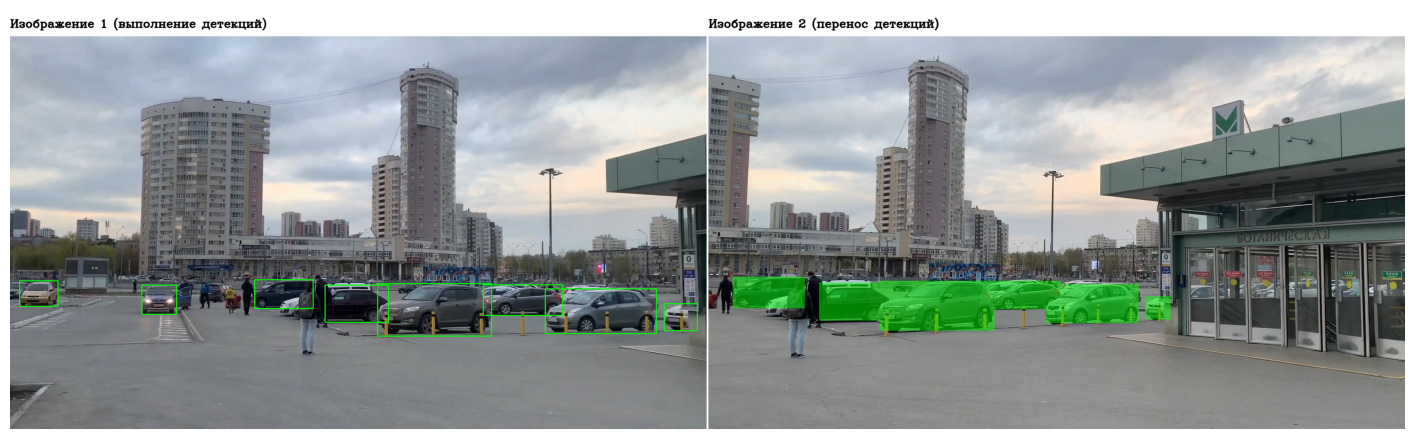

In [ ]:
### 6.1 Transfer detections from the reference frame to the next frame

# We use the first frame as a reference frame.
# Detections are computed on the reference frame and then projected onto a subsequent frame that shares an overlapping view.

homography_coords_transfer(image_1_path='./cam_rotation_cars_dz_pro_1.jpg',
                           image_2_path='./cam_rotation_cars_dz_pro_2.jpg',
                           yolo_detector_model='yolov8s.pt',
                           classes_names=['car'],
                           conf=0.4,
                           sift_points_num=1000,
                           display_result=True)


Результат переноса координат ббоксов детекций с первого изображения на второе изображение, снятое с другого ракурса



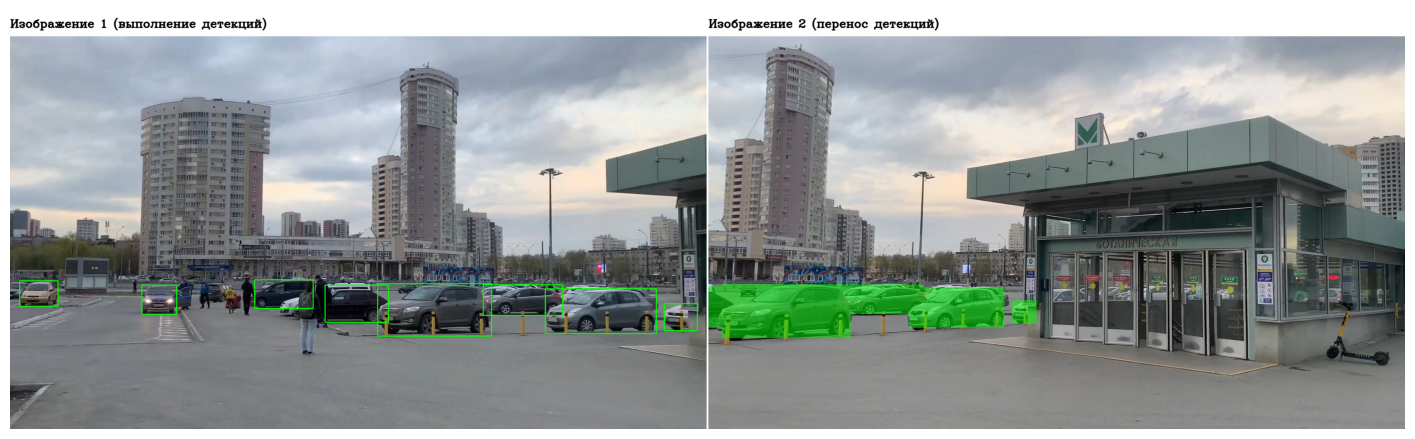

In [ ]:
### 6.2 Transfer detections to a further frame with a larger viewpoint change

# We use the same reference frame, but transfer detections onto a frame captured at a larger rotation angle.
# The key condition is that both frames still share an overlapping region, allowing homography estimation.

homography_coords_transfer(image_1_path='./cam_rotation_cars_dz_pro_1.jpg',
                           image_2_path='./cam_rotation_cars_dz_pro_3.jpg',
                           yolo_detector_model='yolov8s.pt',
                           classes_names=['car'],
                           conf=0.4,
                           sift_points_num=1000,
                           display_result=True)

## Expected Outcome

If two frames share a common planar scene region, feature matching should produce a valid homography matrix.
In this case, bounding boxes detected in the reference frame can be projected onto the target frame with reasonable alignment.

If overlap is insufficient or the scene is strongly non-planar, homography estimation may fail or produce inaccurate projections.
